In [1]:
%load_ext autoreload
%autoreload 2

# Data Exploration
The purpose of this notebook is to explore the MNIST and CIFAR10 datasets

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms
import torch
from torchsummary import summary
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Classify import classification_cnn
import confusion_matrix as cm

# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# # Log into WandB
# wandb.login()

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [6]:
# Define hyperparameters
method = 'decoder'
SNR = 'noiseless'

# Create dict to log into WandB
params = {
  "dataset": f"CIFAR10_mura_{SNR}_reconstructed_{method}_method",#f"CIFAR10_mura_{SNR}_reconstructed_{method}_method",
  "image_size": 23,
  "SNR": SNR,
  "method": method,
  "suffix": f"CIFAR10_{SNR}_reconstructed_{method}_method",#f"CIFAR10_{SNR}_reconstructed_{method}_method",#f"CIFAR10_{SNR}",#f"{SNR}_reconstructed_{method}_method",#f"{SNR}dB" #_reconstructed_{method}_method",
  "batch_size":100,
  # "classes": ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
}

print(f"The dataset loaded will be : {params['dataset']}")

The dataset loaded will be : CIFAR10_mura_noiseless_reconstructed_decoder_method


# Load MNIST Data

In [8]:
# ---------- Define Model, Loss, and Optimizer ----------
model = classification_cnn(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 
wandb.config = model.params
print(model.params['model'])

classification_CIFAR10_noiseless_reconstructed_decoder_method


In [9]:
%time
# Get clean data for baseline test
clean_train_data, clean_eval_data, clean_test_data, clean_loaders = model._get_clean_dataset(model.params)

# Get encoded data 
train_data, eval_data, test_data, loaders = classification_cnn.load_encoded_data(model.params)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Loading dataset from: ../data/CIFAR10/training_CIFAR10_mura_noiseless_reconstructed_decoder_method


In [10]:
# Get ALL data
all_clean_data = clean_train_data + clean_eval_data + clean_test_data
all_mura_data  = train_data       + eval_data       + test_data

In [11]:
%time
# Initialize flat tensors with first element in dataset
flat_clean_data = all_clean_data[0][0].flatten()
flat_mura_data = all_mura_data[0][0].flatten()

for i in range(1, 10000):#len(all_clean_data)):
    # concatenate all remaining flat elements
    flat_clean_data = torch.cat((flat_clean_data, all_clean_data[i][0].flatten()))
    flat_mura_data  = torch.cat((flat_mura_data, all_mura_data[i][0].flatten()))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 11.9 µs


In [12]:
flat_clean_data.shape

torch.Size([5290000])

In [13]:
529*100

52900

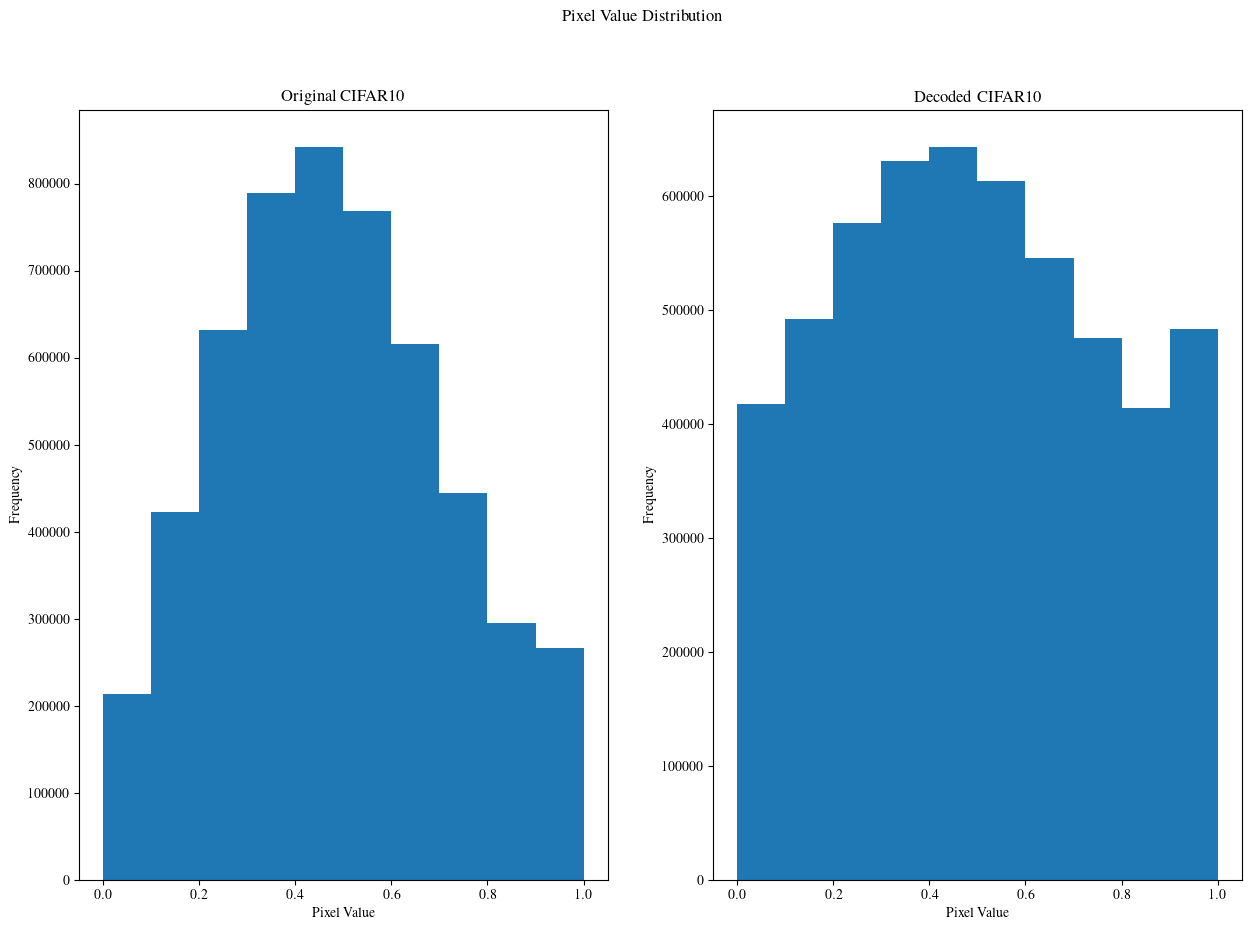

In [15]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
# Plot the histogram
axs[0].hist(flat_clean_data, range=(0, 1))
axs[0].set_title("Original CIFAR10")
axs[0].set_xlabel("Pixel Value")
axs[0].set_ylabel("Frequency")

axs[1].hist(flat_mura_data, range=(0, 1))
axs[1].set_title("Decoded CIFAR10")
axs[1].set_xlabel("Pixel Value")
axs[1].set_ylabel("Frequency")
plt.suptitle("Pixel Value Distribution")
plt.show()

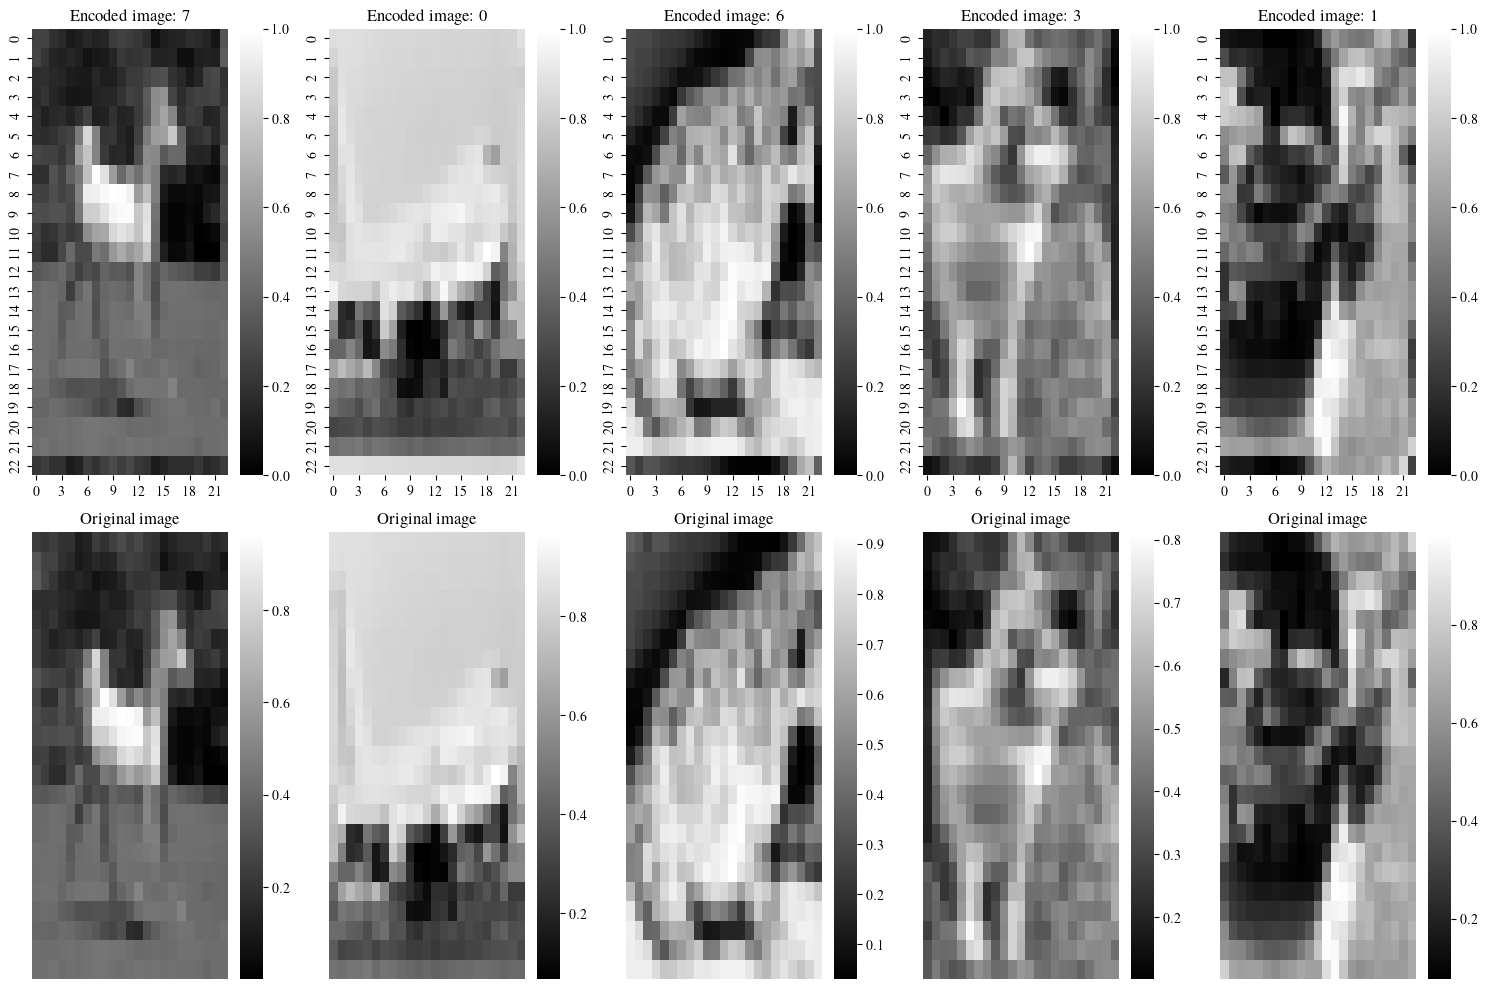

In [14]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(train_data[idx][0].squeeze(), cmap='gray')
    plt.title(f'Encoded image: {train_data[idx][2]}')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(train_data[idx][1].squeeze(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

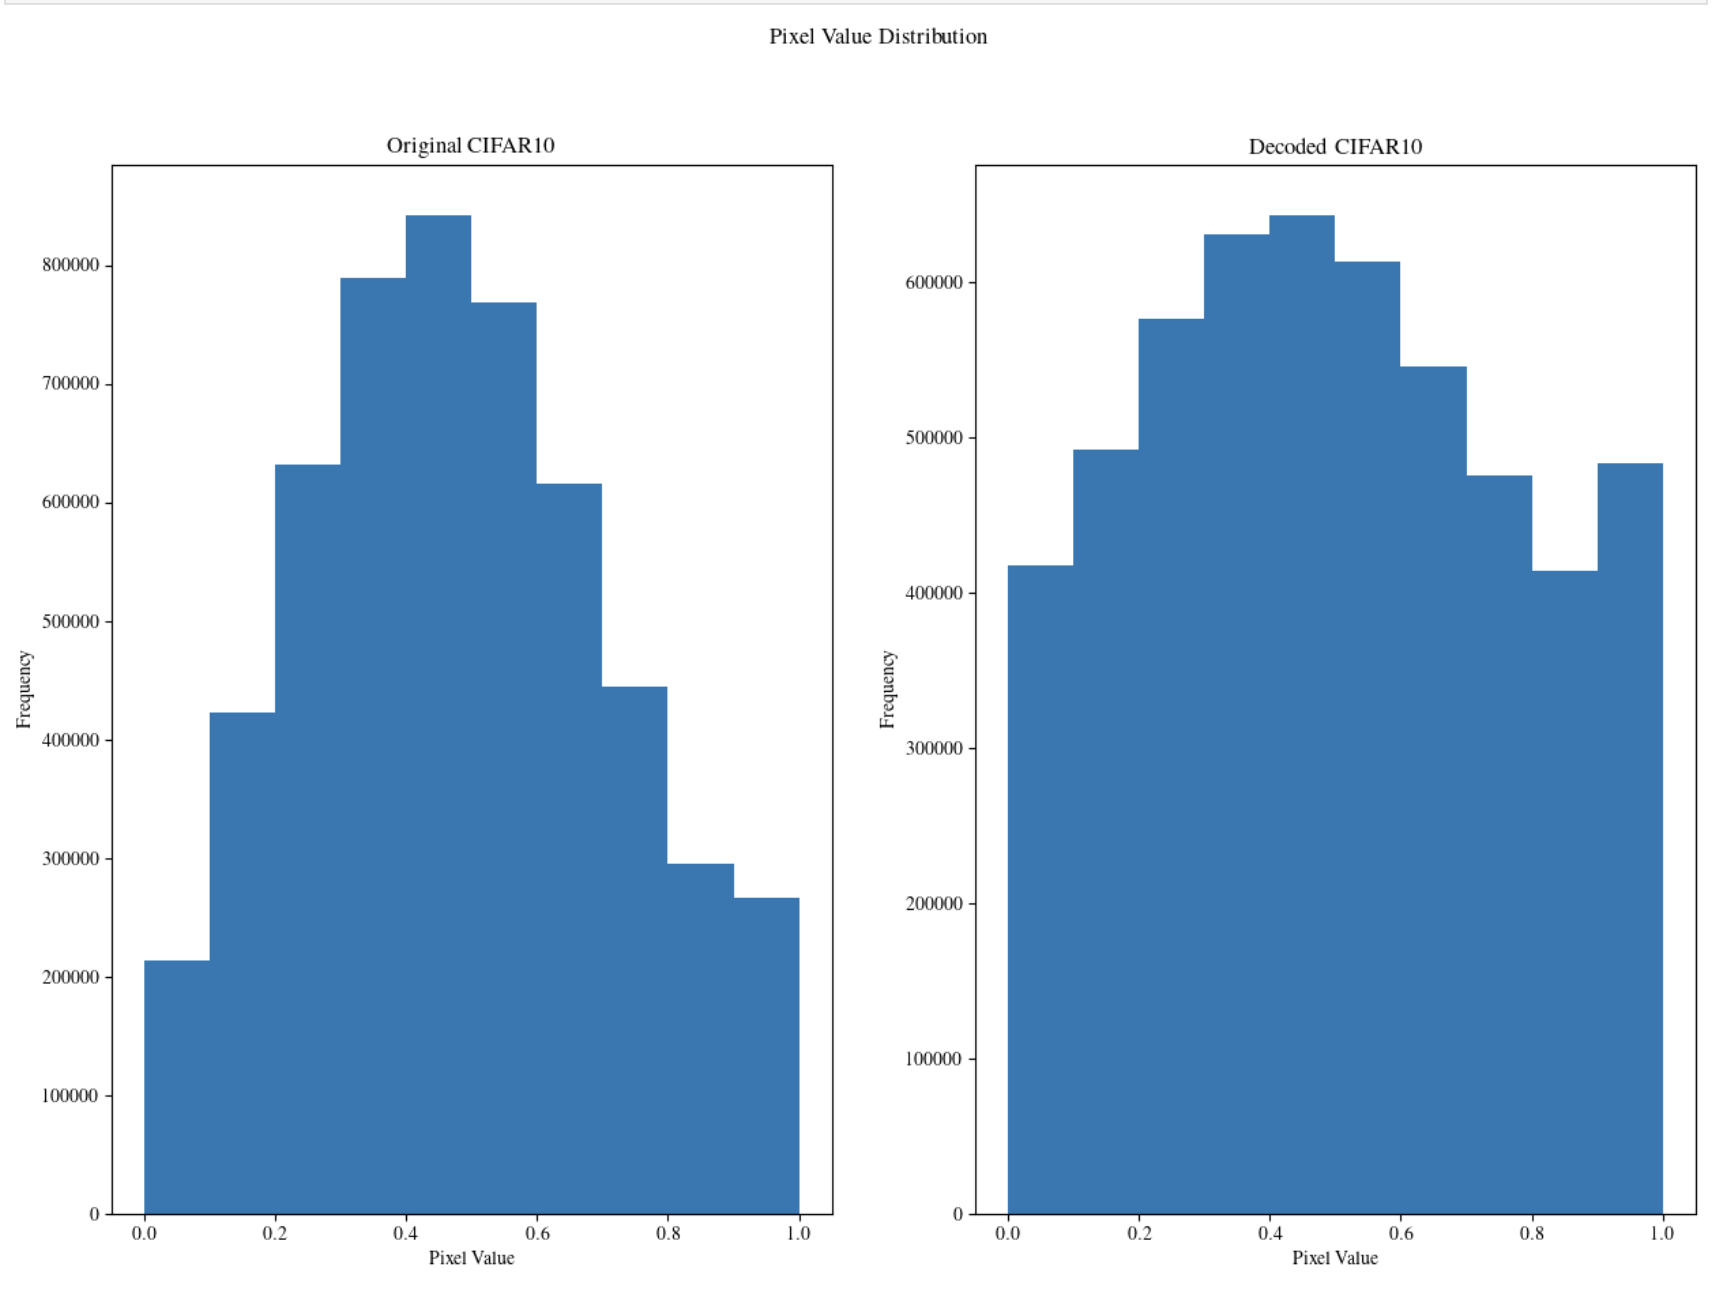